<a href="https://colab.research.google.com/github/EpicOne1/7318-Deep-Learning/blob/master/VGG11_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
device

device(type='cuda', index=0)

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [19]:
import torch.nn as nn
import torch.nn.functional as F

# VGG11 ConvNet configuration is 'A', 'M' = Max pooling layer
# B is reduced size networks 
cfgs = {'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        'B': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M'],
        'C': [64, 'M', 128, 'M', 256, 256, 'M']}

def make_layers(cfg):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else: 
            # add convolutional layer and Batch Norm
            layers.append(nn.Conv2d(in_channels=in_channels,
                                    out_channels=v,
                                    kernel_size=3,
                                    stride=1,
                                    padding=1,
                                    bias=True))
            layers.append(nn.BatchNorm2d(v))
            layers.append(nn.ReLU(inplace=True))
            in_channels = v
    return nn.Sequential(*layers)



class VGG(nn.Module):
    # 10 classes
    def __init__(self, name, num_classes=10, init_weights = True):
        super(VGG, self).__init__()
        # VGG11_D
        cfg = cfgs[name]
        self.layers = make_layers(cfg)
        self.avgpool = nn.AdaptiveAvgPool2d((3,3)) # change 7x7 to 3x3
        self.classifier = nn.Sequential(
            nn.Linear(256*3*3, 512), #fc1
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512,256), #fc2
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, num_classes) #fc3
        )
        if init_weights:
            self._initialize_weights()
            
    def forward(self,x):
        x = self.layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    
def VGG11_C():
  return VGG('C')

    
net = VGG11_C().to(device)
print(net)

VGG(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kern

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9, weight_decay = 5*1e-4)

In [21]:
training_acc = []
test_acc = []
train_loss = []

for epoch in range(25): # loop over the dataset 25 times (1 epoch = all training samples)
    
    running_loss = 0.0
    # ith mini-batch, 1 mini-batch has 64 training samples 
    # batch size = 64
    for i, data in enumerate(trainloader, 0):
        # get inputs; the data is presented as a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward 
        outputs = net(inputs)
        # calculate loss
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # update parameter (optimize)
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i%125 == 124: # print every 125 mini-batches, 125*64 samples
            print('[%d, %5d] loss: %.3f' %
                 (epoch+1, i+1, running_loss/125))
            # every 125 mini-batches, reset running_loss    
            # because it is accumulated for each mini-batches
            train_loss.append(running_loss/125)
            running_loss = 0.0
            
    
    # training and test accuracy for each epoch
    # train
    correct = 0
    total = 0
    # no_grad(): reduce memory consumption for computations
    with torch.no_grad():
        # load data from training set
        for data in trainloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        training_acc.append(100 * correct / total)
        
    # test     
    correct = 0
    total = 0
    # no_grad(): reduce memory consumption for computations
    with torch.no_grad():
        # load data from test set
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_acc.append(100 * correct / total)    
        
print("Finished Training")

[1,   125] loss: 2.301
[1,   250] loss: 2.294
[1,   375] loss: 2.271
[1,   500] loss: 2.193
[1,   625] loss: 2.031
[1,   750] loss: 1.904
[2,   125] loss: 1.822
[2,   250] loss: 1.779
[2,   375] loss: 1.740
[2,   500] loss: 1.707
[2,   625] loss: 1.668
[2,   750] loss: 1.636
[3,   125] loss: 1.604
[3,   250] loss: 1.552
[3,   375] loss: 1.548
[3,   500] loss: 1.497
[3,   625] loss: 1.471
[3,   750] loss: 1.426
[4,   125] loss: 1.399
[4,   250] loss: 1.349
[4,   375] loss: 1.327
[4,   500] loss: 1.325
[4,   625] loss: 1.308
[4,   750] loss: 1.255
[5,   125] loss: 1.228
[5,   250] loss: 1.234
[5,   375] loss: 1.188
[5,   500] loss: 1.159
[5,   625] loss: 1.170
[5,   750] loss: 1.135
[6,   125] loss: 1.114
[6,   250] loss: 1.084
[6,   375] loss: 1.075
[6,   500] loss: 1.079
[6,   625] loss: 1.035
[6,   750] loss: 1.046
[7,   125] loss: 1.022
[7,   250] loss: 0.984
[7,   375] loss: 0.988
[7,   500] loss: 0.976
[7,   625] loss: 0.951
[7,   750] loss: 0.957
[8,   125] loss: 0.922
[8,   250] 

In [22]:
PATH = './VGG11_C.pth'
torch.save(net.state_dict(), PATH)


In [23]:
net = VGG11_C()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

VGG11_2FC

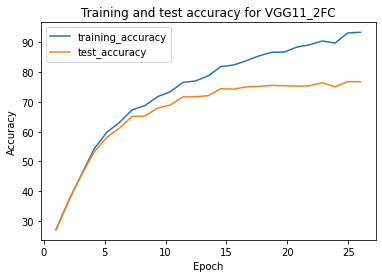

In [26]:
import matplotlib.pyplot as plt
import numpy as np
epoch = np.linspace(1,26,25)
fig = plt.figure()
plt.plot(epoch, training_acc, label = 'training_accuracy')
plt.plot(epoch, test_acc, label = 'test_accuracy')
plt.title('Training and test accuracy for VGG11_2FC')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
fig.savefig('VGG11_2FC_result.jpg')

VGG11_FC

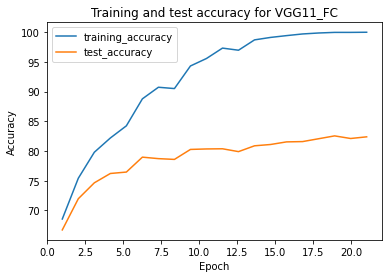

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epoch = np.linspace(1,21,20)
fig = plt.figure()
plt.plot(epoch, training_acc, label = 'training_accuracy')
plt.plot(epoch, test_acc, label = 'test_accuracy')
plt.title('Training and test accuracy for VGG11_FC')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
fig.savefig('VGG11_FC_result.jpg')

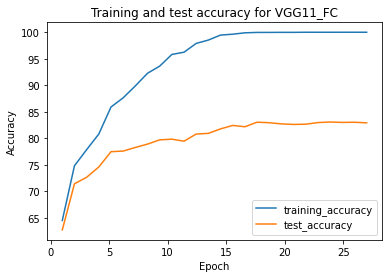

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epoch = np.linspace(1,27,26)
fig = plt.figure()
plt.plot(epoch, training_acc, label = 'training_accuracy')
plt.plot(epoch, test_acc, label = 'test_accuracy')
plt.title('Training and test accuracy for VGG11_FC')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
fig.savefig('VGG11_FC_result.jpg')

In [24]:
# test for each class
class_correct = list(0. for i in range(10))
# class_correct = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        # c will be a tensor contain 0 and 1, 1:predict correct
        c = (predicted == labels).squeeze()
        # batch size = 4
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item() 
            class_total[label] += 1

# print result
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
    classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 78 %
Accuracy of   car : 78 %
Accuracy of  bird : 72 %
Accuracy of   cat : 60 %
Accuracy of  deer : 81 %
Accuracy of   dog : 61 %
Accuracy of  frog : 78 %
Accuracy of horse : 85 %
Accuracy of  ship : 87 %
Accuracy of truck : 88 %
